In [6]:
import os
import pandas as pd
import networkx as nx

datapath = 'C:/Users/spbro/Documents/python/InstaGraph/data/spbroma/relationship_data'
root = 'spbroma'

In [821]:

def get_followings(user):
    path = os.path.join(datapath, user)
    path = os.path.join(path, 'following')

    if os.path.exists(path):

        files = [f.path for f in os.scandir(path) if f.is_file()]

        file = files[-1]

        followings = pd.read_json(file)
        followings = list(followings[0])
    else:
        followings = []
        print(f'No data about {user}\'s followings')

    return followings


def remove_root_followings(df: pd.DataFrame, root_followings: list):
    for f in root_followings:
        df = df[df['username'] != f]

    return df

def get_followers(df, name):
    return df[df['username'] == name]['followers'].iloc[0]
    

def gen_layout_pos(df_plot):
    followings = list(set(df_plot['username']))

    N = len(followings)
    node_indices = list(range(N))

    circ = [i*2*np.pi/N for i in node_indices]
    x = [math.sin(i) for i in circ]
    y = [math.cos(i) for i in circ]

    pos_dict = dict(zip(followings, zip(x,y)))
    return pos_dict




# Raw data proceed

In [404]:
summary_dict = {}
root_followings = get_followings(root)



for f in root_followings:
    child_followings = get_followings(f)
    for user in child_followings:
        if user in summary_dict.keys():
            summary_dict[user]['followers'].append(f)
            summary_dict[user]['count'] += 1
        else:
            tmp_dict = {'followers': [f], 'count': 1}
            summary_dict[user] = tmp_dict
            
        
        

df = pd.DataFrame.from_dict(summary_dict, orient='index')
df = df.sort_values(by=['count'], ascending=False)
df = df.reset_index()
df = df.rename(columns={'index': 'username'})


df_filt = remove_root_followings(df, root_followings+[root])


    # df_filt[df_filt['username']=='musiatotibadze']['followers'].iloc[0]

No data about another_moscow_'s followings
No data about interesno.art's followings
No data about seryonyamur's followings
No data about tima_radya's followings
No data about anfi_academy's followings
No data about banksy's followings
No data about cinemagraphie's followings
No data about dream.detailing's followings
No data about batenka.ru's followings
No data about spencertunick's followings
No data about eva.stories's followings
No data about givemegram's followings
No data about metro178's followings
No data about mariaplyusnina's followings
No data about durov's followings
No data about eroticwatercolor's followings
No data about nagiev.universal's followings
No data about prtbrt's followings
No data about letoran's followings
No data about mikhail_ognev's followings
No data about shushlove_psy's followings
No data about syuskova_alisa's followings
No data about myhoodisgood's followings
No data about pictorialart.ru's followings
No data about platon_yurich's followings
No data a

## Threshold output

In [662]:
df_out = df_filt
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_out[df_out['count'] > 5][['username', 'count']])

In [666]:
df[df['count']>10][['username']].to_csv('influencers.csv', index=False)

## Select item

In [421]:
df_filt[df_filt['username']=='labkovskiyofficial']['followers'].iloc[0]

['irenaponaroshku',
 'irinabolotova',
 'svetik_luchnikova',
 'llllllll1111llllllllll',
 'kkorchagina',
 'aivanyuta',
 'tiutya',
 'comangkatarios',
 'marisabelchik2610',
 'chudowoman',
 'v.e.s',
 'md_md_71',
 'vaseninfamily',
 'golyanishcheva',
 'stasya1788',
 'temalebedev',
 'alexislyapin',
 'ginger.minion',
 'chudophotos',
 'natburg',
 'thesedgw',
 'belozerova_elen',
 'anna_kordubailo']

## Remap

In [728]:
users_map = pd.read_csv('influencers_rating.csv')
# users_map = users_map.replace(np.nan, -1)
# del users_map[users_map['rate'] == -1]
users_map = users_map.dropna()

map_dict = {1: 'scum',
            2: 'suspicious',
            3 : 'casual', 
            4 : 'interesting'}

users_map = users_map.replace(map_dict)


users_map_dict = dict(zip(users_map['username'], users_map['rate']))

df_remap = df.replace(users_map_dict)
df_remap = df_remap[df_remap['username'].isin(list(map_dict.values()))]


# Plot graph

In [726]:

def get_nodeId_by_name(pos, name):
    return np.where(np.array(list(pos.keys())) == name)[0][0]

def get_graph_primitives(G, pos):
    x, y, edges_start, edges_end = [], [], [], []

    for p in pos:
        x.append(pos[p][0])
        y.append(pos[p][1])

    for e in list(G.edges):
        st = e[0]
        en = e[1]
        st = get_nodeId_by_name(pos, st)
        en = get_nodeId_by_name(pos, en)
        edges_start.append(st)
        edges_end.append(en)
    
    return x, y, edges_start, edges_end


'''''
def add_graph_data(G, graph, source, source_edges):
    source_df = source.to_df()

    # How it should be
#     graph.node_renderer.data_source = source # I have no idea, why it doesn't work properly
    
    # Working variant - 1
    graph.node_renderer.data_source.data = source.to_df().to_dict(orient='list')
    
    
    # Working variant - 2
#     graph.node_renderer.data_source.add(node_indices, 'index')
#     for k in source_df.keys():
#         graph.node_renderer.data_source.add(source_df[k], k)
    
    # Working variant - 3
#     graph.node_renderer.data_source.add(source_df['name'], 'name')
#     graph.node_renderer.data_source.add(source_df['influencer'], 'influencer')
#     graph.node_renderer.data_source.add(source_df['x'], 'x')
#     graph.node_renderer.data_source.add(source_df['y'], 'y')

    
    # Edges. Working - 1
#     graph.edge_renderer.data_source.data = dict(
#         start=edges_start,
#         end=edges_end)

    # Edges. Working - 2
    graph.edge_renderer.data_source.data = source_edges.to_df().to_dict(orient='list')
    
    return graph
'''''

def add_graph_style(graph):
    # graph.node_renderer.data_source.add(Spectral8, 'color')
#     node_size = 20
    node_size = 'node_size'
    # graph.node_renderer.data_source = source
    graph.node_renderer.glyph = Circle(size=node_size, fill_color=Spectral4[0])
    graph.node_renderer.selection_glyph = Circle(size=node_size, fill_color=Spectral4[2])
    graph.node_renderer.hover_glyph = Circle(size=node_size, fill_color=Spectral4[1])

    graph.edge_renderer.glyph = MultiLine(line_color="#f46d43", line_width=1, line_alpha=0.1)
    graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
    graph.edge_renderer.hover_glyph = MultiLine(line_color="#f46d43", line_width=2, line_alpha=0.5)

    graph.inspection_policy = NodesAndLinkedEdges()    
    return graph
    
    

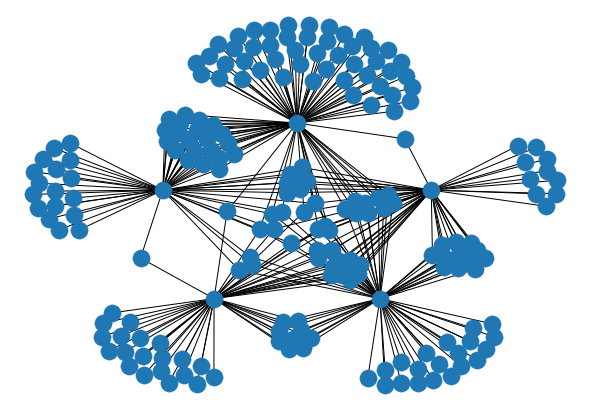

In [827]:

G = nx.Graph()

df_plot = df_filt.head() # {df, df_filt, df_remap}

cntr = 0
for index, row in df_plot.iterrows():
#     print(index, row['username'])
    following = row['username']
    cntr += 1
    
    for follower in row['followers']:
        G.add_edge(following, follower)
        G.nodes[follower]['name'] = follower
        G.nodes[follower]['influencer'] = ''
        G.nodes[follower]['node_size'] = 5
        
    G.nodes[following]['name'] = following
    G.nodes[following]['influencer'] = following
    try:
        n_followers = int(len(get_followers(df, following))/3.0)
    except:
        n_followers = 20
    G.nodes[following]['node_size'] = n_followers


pos_dict = gen_layout_pos(df_plot)

fixed_nodes = pos_dict.keys()
pos = nx.spring_layout(G,pos=pos_dict, fixed = fixed_nodes, iterations=50, k=0.2)
# pos = nx.spring_layout(G, dim=2, iterations=200, fixed=[''])

for p in pos:
#     print(p)
    G.nodes[p]['x'] = pos[p][0]
    G.nodes[p]['y'] = pos[p][1]    


nx.draw(G, pos)
# node_labels = nx.get_node_attributes(G, 'influencer')
# nx.draw_networkx_labels(G, pos, labels = node_labels)



## Manual graph creation

In [829]:
from bokeh.io import output_notebook, show
from bokeh.models import Ellipse, GraphRenderer, StaticLayoutProvider
from bokeh.palettes import Spectral8
from bokeh.plotting import figure


    

# Graph data preprocess
x, y, edges_start, edges_end = get_graph_primitives(G, pos)

TOOLTIPS = [
    ('', "@name"),
]

plot = figure(plot_width=1600, plot_height=800,
              title='InstaGraph', x_range=(-2,2), y_range=(-1, 1),
              tools='hover,pan,wheel_zoom,box_zoom,reset,lasso_select', 
              active_drag="lasso_select", 
              active_scroll='wheel_zoom',
              tooltips=TOOLTIPS)
plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None

graph = GraphRenderer()

source = ColumnDataSource(pd.DataFrame.from_dict({k:v for k,v in G.nodes(data=True)}, orient='index'))
source_edges = ColumnDataSource(pd.DataFrame([[k,v] for k,v,_ in G.edges(data=True)], columns=['start', 'end']))

# node_indices = list(range(N))
node_indices = source.to_df()['index']

graph.node_renderer.data_source.data = source.to_df().to_dict(orient='list')
graph.edge_renderer.data_source.data = source_edges.to_df().to_dict(orient='list')
graph = add_graph_style(graph)


graph_layout = dict(zip(node_indices, zip(x, y)))
graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

plot.renderers.append(graph)

labels = LabelSet(x='x', y='y', text='influencer', source=source,
                  x_offset=5, y_offset=5,
                  text_font_size='10pt',
                  background_fill_color='white', background_fill_alpha=0.7)

labels_all = LabelSet(x='x', y='y', text='name', source=source,
                  x_offset=5, y_offset=5,
                  text_font_size='6pt',
                  background_fill_color='white', background_fill_alpha=0.5)
plot.add_layout(labels_all)
plot.add_layout(labels)

output_notebook()
show(plot)

Loading BokehJS ...

In [572]:
graph = GraphRenderer()

# graph = add_graph_data(G, graph, source)
# graph.node_renderer.data_source = source
graph.node_renderer.data_source.add(node_indices, 'index')

# graph.layout_provider.to_json(True)
graph.node_renderer.data_source.to_df()

index
0       anton_lapenko
1         anastasiapo
2          rudakov_aa
3           hey_daria
4          bad.planet
..                ...
139    eyesofmedicine
140         mindz.eye
141      ksunamoonmiu
142  valeriimuromtsev
143        thehoxband

[144 rows x 1 columns]

## Directly from Graph
but coordinates doesn't transfer directly

In [542]:
import networkx as nx

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, from_networkx
from bokeh.models import ColumnDataSource, Circle, Line, MultiLine, LabelSet
from bokeh.palettes import Spectral4
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes

TOOLTIPS = [
    ('name', "@name"),
    ('x', "@x"),
#     ('index', "@influencer"),
]


plot = figure(plot_width=1200, plot_height=600, title="Instagraph", x_range=(-2,2), y_range=(-1,1), 
              tools='hover,pan,wheel_zoom,box_zoom,reset', tooltips=TOOLTIPS)

graph = from_networkx(G, nx.spring_layout, scale=-1, center=(0,0))

source = ColumnDataSource(pd.DataFrame.from_dict({k:v for k,v in G.nodes(data=True)}, orient='index'))

#style
node_size = 7
# graph.node_renderer.data_source = source
graph.node_renderer.glyph = Circle(size=node_size, fill_color=Spectral4[0])
graph.node_renderer.selection_glyph = Circle(size=node_size, fill_color=Spectral4[2])
graph.node_renderer.hover_glyph = Circle(size=node_size, fill_color=Spectral4[1])

graph.edge_renderer.glyph = MultiLine(line_color="#f46d43", line_width=1, line_alpha=0.1)
graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph.edge_renderer.hover_glyph = MultiLine(line_color="#f46d43", line_width=3, line_alpha=0.5)

labels = LabelSet(x='x', y='y', text='influencer', source=source)
plot.add_layout(labels)

graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph)

output_notebook()
show(plot)

Loading BokehJS ...

In [330]:
graph = GraphRenderer()

source = ColumnDataSource(pd.DataFrame.from_dict({k:v for k,v in G.nodes(data=True)}, orient='index'))

graph.node_renderer.data_source.add(node_indices, 'index')
graph.node_renderer.data_source.add(source.to_df()['name'], 'name')
graph.node_renderer.data_source.add(source.to_df()['influencer'], 'influencer')
graph.node_renderer.data_source.add(source.to_df()['x'], 'x')
graph.node_renderer.data_source.add(source.to_df()['y'], 'y')

graph1 = GraphRenderer()

graph1.node_renderer.data_source = source
graph1.node_renderer.data_source.add(node_indices, 'index')

graph == graph1

False

In [336]:
graph.node_renderer.to_json()

TypeError: to_json() missing 1 required positional argument: 'include_defaults'

In [339]:
graph1.node_renderer.equals(graph.node_renderer)

False